In [40]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd
#import re
#import requests
import seaborn as sns
import seaborn.objects as so
#import string
import tensorflow as tf
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
# nltk.download('stopwords')

## Load Data

In [41]:
file = 'Projects Materials/job_complexity.csv'

In [42]:
data = pd.read_csv(file,
                   usecols= ['pay_band', 'job_title', 'complexity'],
                   #dtype={'pay_band': 'category'}
                   )

data.head()

,pay_band,job_title,complexity
0,1,Administrative and Office Specialist I,Performs routine office support activities.\nW...
1,2,Administrative and Office Specialist II,Applies knowledge of office/program support ac...
2,3,Administrative and Office Specialist III,"Acts as a specialist in assigned program area,..."
3,1,Agricultural Specialist I,Performs a variety of duties in support of sea...
4,2,Agriculture Specialist II,Performs a variety of duties in support of sea...


Shuffle the rows of the data frame so the training and testing sets contain a random sample of jobs.

In [43]:
data = data.sample(len(data), random_state=322)
data.head()

,pay_band,job_title,complexity
221,7,Minerals Manager II,"Applies knowledge of laws, rules and regulatio..."
290,6,Health Care Compliance Manager,Directs a major organizational component of an...
184,4,Printing Manager I,Applies knowledge of the principles of managem...
28,2,Trades Technician II,Applies knowledge of basic trade area.\nApplie...
43,7,Dental Manager,Applies knowledge of all functions of a compre...


In [44]:
X = data.loc[:, data.columns.drop(['pay_band', 'job_title'])]
y = data.loc[:, 'pay_band']
jobs = data.loc[:, 'job_title']
X.head()

,complexity
221,"Applies knowledge of laws, rules and regulatio..."
290,Directs a major organizational component of an...
184,Applies knowledge of the principles of managem...
28,Applies knowledge of basic trade area.\nApplie...
43,Applies knowledge of all functions of a compre...


## Explaoratory Data Analysis

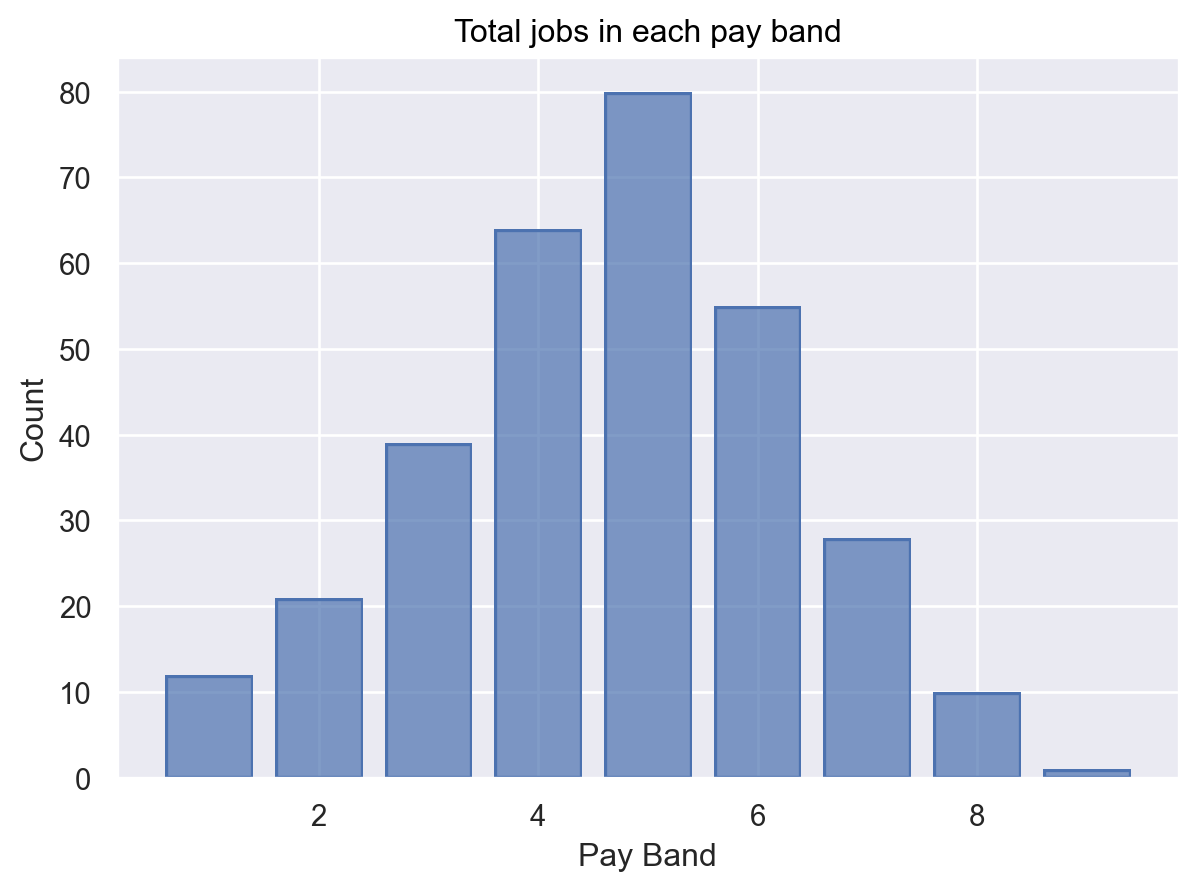

In [45]:
# The data set is imbalanced, but it does make sense that pay grade assignment would be normally distributed
(so.Plot(data, x='pay_band')
 .add(so.Bar(), so.Count())
).label(title='Total jobs in each pay band', x='Pay Band', y='Count')

In [46]:
word_count = pd.DataFrame(data) # copy data set
word_count['freq'] = word_count['complexity'].apply(lambda x: Counter(x.lower().split())) # get frequency of words in each instance
common_wrds = word_count['freq'].sum() # sum frequency of words in corpus
word, count = zip(*common_wrds.most_common(10)) # identify top 10 recurring words

##### The complexity attribute contains 3,301 unique words 

In [47]:
len(common_wrds)

3301

##### The longest complexity description is 247 words

In [48]:
row_count=[]
for i in range(len(word_count)):
    row_count.append(len(word_count['complexity'][i].split())) # add row words counts to list
print(max(row_count), min(row_count)) # identify minimum and maximum lengths

247 8


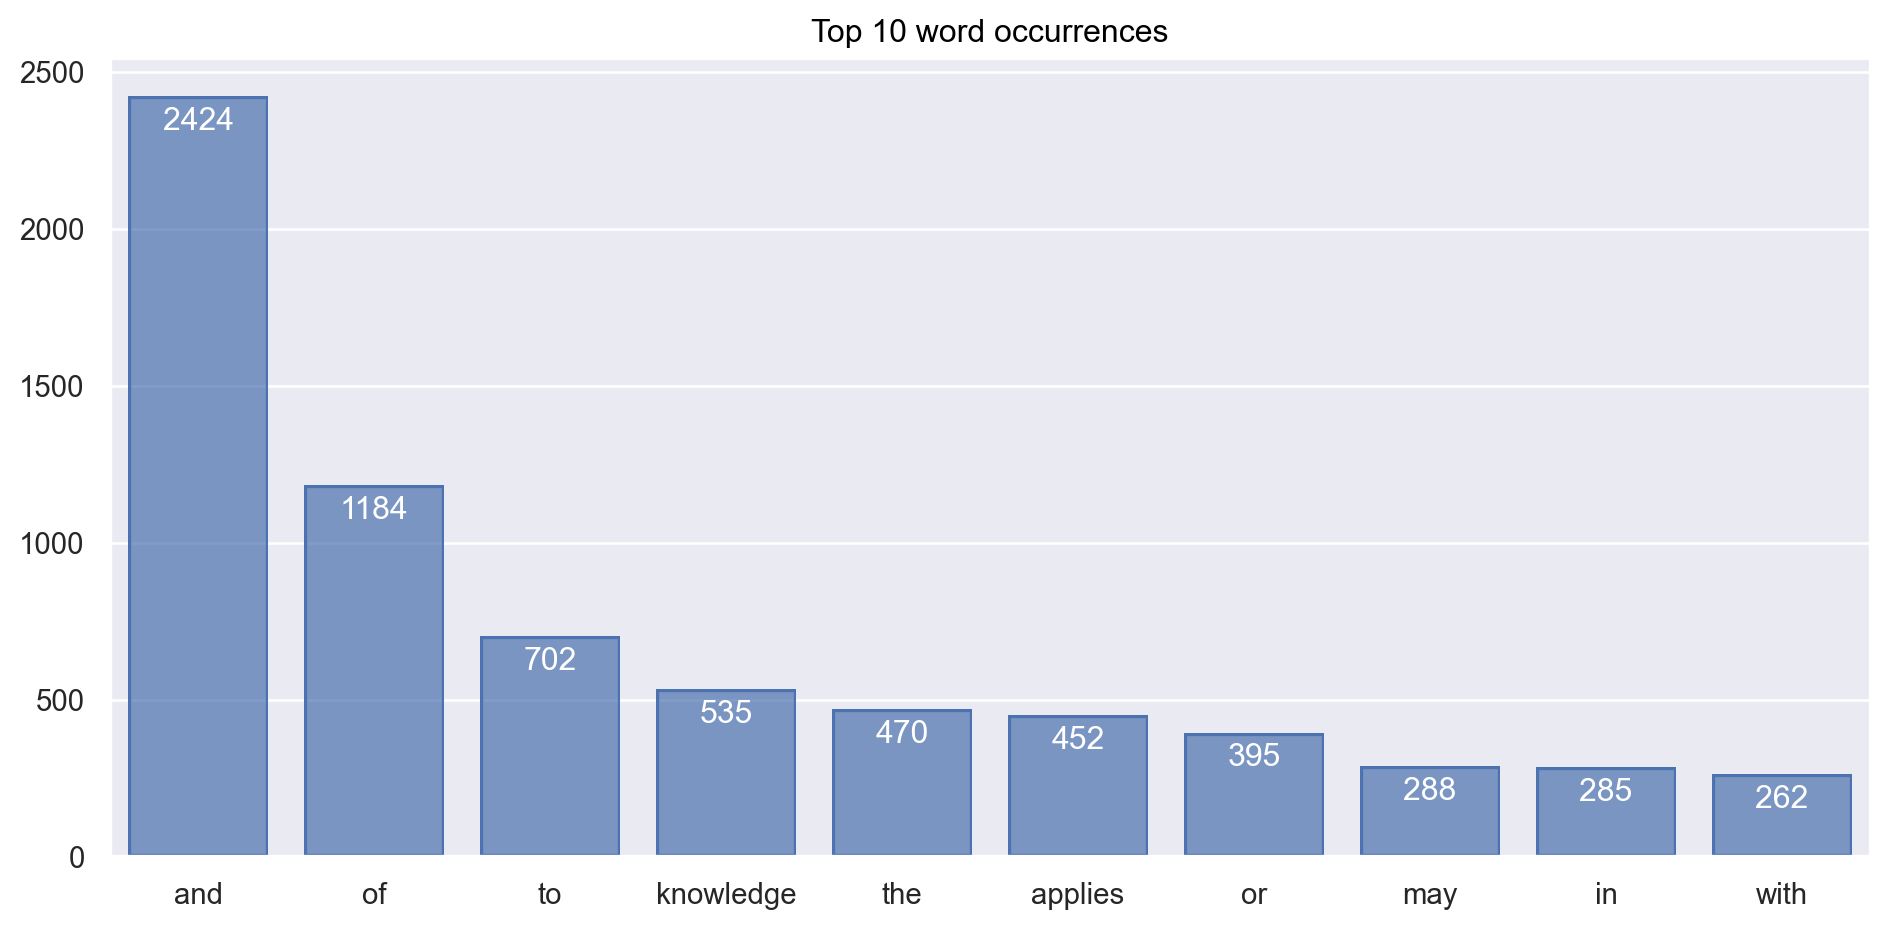

In [49]:
(so.Plot(x=word, y=count, text=count)
 .add(so.Bar())
 .add(so.Text(color='w', valign='top'))
 ).layout(size=(10,5)).label(title='Top 10 word occurrences')

##### Create stop words list and remove them from the data frame

In [50]:
add = ['and/or', 'may', 'state']
keep = ['above', 'below', 'more', 'most', 'few', 'some']

new_stopwords = set(stopwords.words('english'))
new_stopwords.update(add) # add words to list
new_stopwords.difference(keep) # retain words already on list

{'a',
 'about',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'and/or',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'may',
 'me',
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our

In [51]:
for row in range(len(X)):
    df_line = X['complexity'][row].split()
    X.loc[row, 'complexity'] = ' '.join([word for word in df_line if word not in new_stopwords]) # reomve stop words from corpus

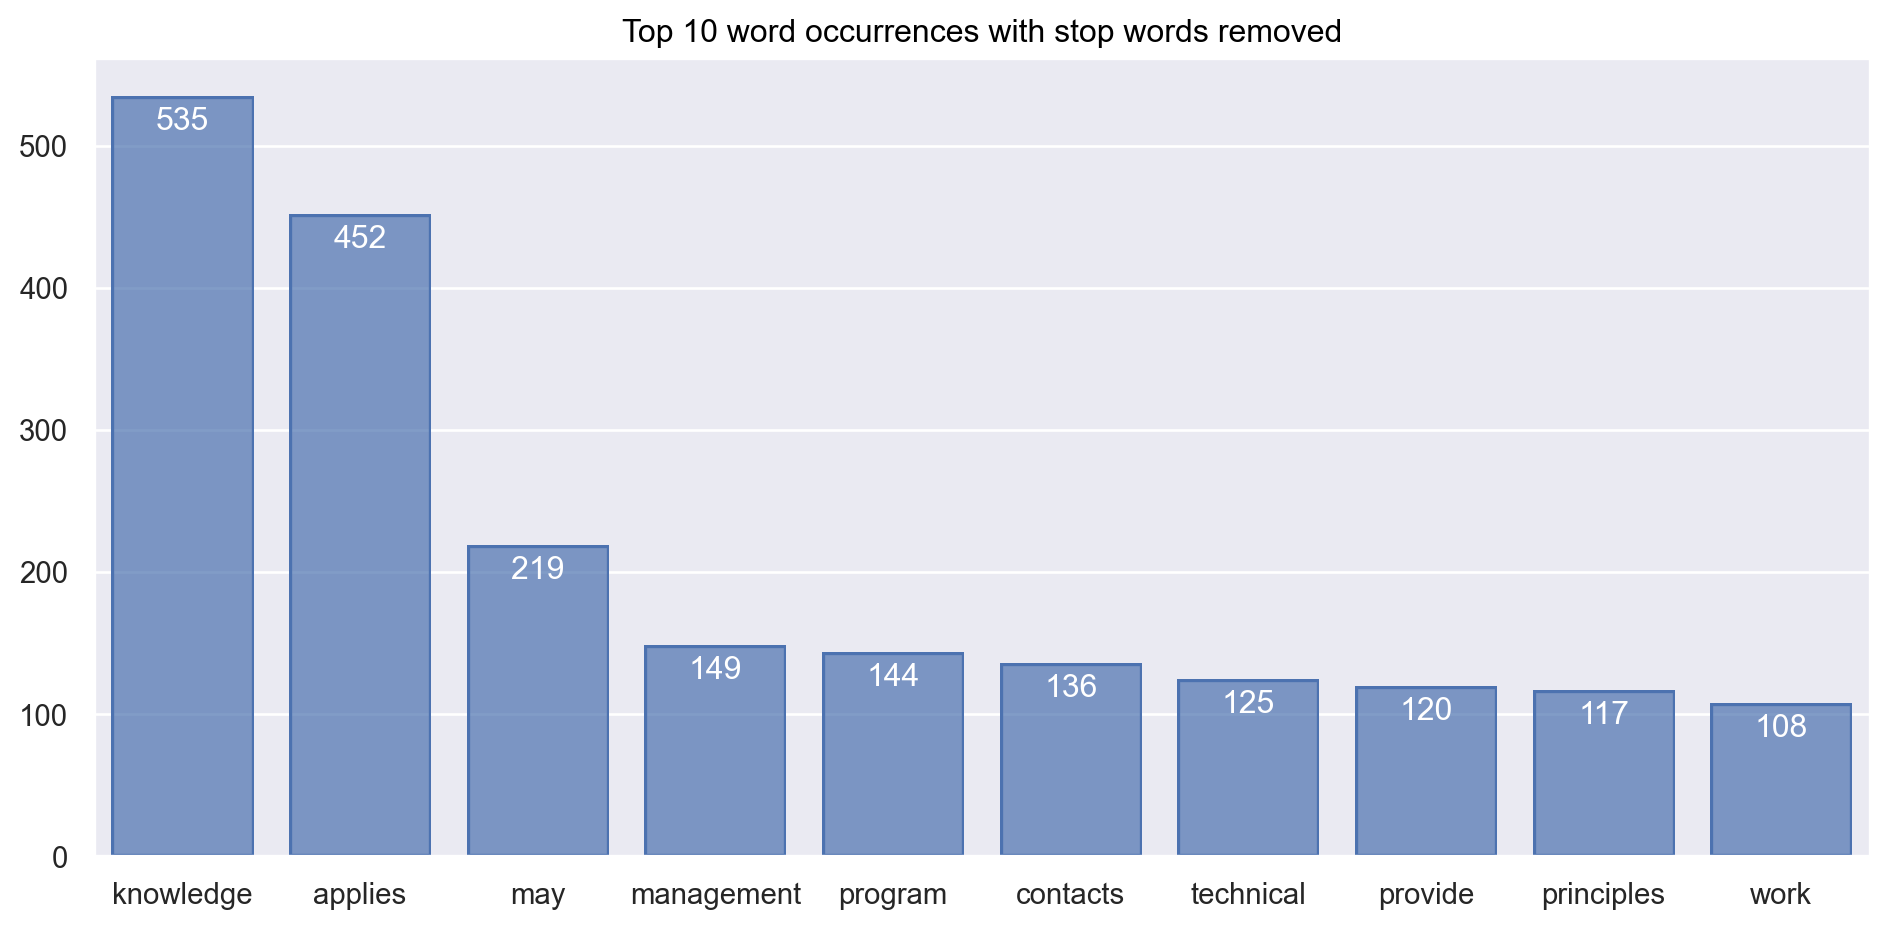

In [52]:
sw_removed = pd.DataFrame(X).copy()
sw_removed['freq'] = sw_removed['complexity'].apply(lambda x: Counter(x.lower().split())) # get frequency of words in each instance with stop words removed
new_common_wrds = sw_removed['freq'].sum() # sum frequency of words in corpus with stop words removed
new_word, new_count = zip(*new_common_wrds.most_common(10)) # get updated top 10 list with stop words removed



(so.Plot(x=new_word, y=new_count, text=new_count)
 .add(so.Bar())
 .add(so.Text(color='w', valign='top'))
 ).layout(size=(10,5)).label(title='Top 10 word occurrences with stop words removed')

#### After removing stop words, the corpus contains 3,251 unique words.

In [53]:
len(list(new_common_wrds))

3247

##### The longest complexity description is 190 words with stop words removed

In [54]:
new_row_count=[]
for i in range(len(X)):
    new_row_count.append(len(X['complexity'][i].split()))
print(max(new_row_count), min(new_row_count)) # get new minimum and maximum word coutns by row

190 5


## Preprocessing

In [55]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30, random_state=322)

##### Convert feature sets to tensors

In [56]:
tensor_train = tf.convert_to_tensor(X_train)
tensor_test = tf.convert_to_tensor(X_test)

#### Create text vectorizer

In [57]:
tensor = tf.convert_to_tensor(X) # Convert corpus features to tensor

In [58]:
size = 3250 # Total of 3,248 tokens since out-of-vocabuary token=-1 and output_mode of int (defeault)= -1
length = max(new_row_count) # set length of each vectorized feature

text_vectorize = TextVectorization(max_tokens=size, output_sequence_length=length)
text_vectorize.adapt(tensor)

# https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/

In [59]:
# Subtract 1 from paygrades to mitigate need for integers in output layer of sequential model
convert_y_train = y_train-1
convert_y_test = y_test-1

## Neural Network

In [71]:
np.random.seed(322)
tf.random.set_seed(322)

embed_dim = 32


txt_model = tf.keras.Sequential([
    text_vectorize,
    tf.keras.layers.Embedding(size, embed_dim, mask_zero=True, name='embedding_layer'),
    tf.keras.layers.GRU(32, name='memory_layer'),
    tf.keras.layers.Dense(9, activation='softmax', name='output_layer')
])

txt_model.compile(
    loss='sparse_categorical_crossentropy', # used for integer labels
    optimizer='adam',
    metrics=['accuracy', 'sparse_categorical_accuracy', 
             'f1_score', 'sparse_categorical_crossentropy'],
)

txt_class = txt_model.fit(tensor_train, convert_y_train, epochs=50, validation_data=(tensor_test, convert_y_test))


# https://keras.io/api/optimizers/adam/
# https://keras.io/api/metrics/accuracy_metrics/#sparsecategoricalaccuracy-class

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.1167 - f1_score: 0.2125 - loss: 2.1938 - sparse_categorical_accuracy: 0.1167 - sparse_categorical_crossentropy: 2.1938 - val_accuracy: 0.1613 - val_f1_score: 0.2007 - val_loss: 2.1787 - val_sparse_categorical_accuracy: 0.1613 - val_sparse_categorical_crossentropy: 2.1787
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3777 - f1_score: 0.1944 - loss: 2.1595 - sparse_categorical_accuracy: 0.3777 - sparse_categorical_crossentropy: 2.1595 - val_accuracy: 0.1613 - val_f1_score: 0.1949 - val_loss: 2.1592 - val_sparse_categorical_accuracy: 0.1613 - val_sparse_categorical_crossentropy: 2.1592
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3880 - f1_score: 0.1894 - loss: 2.1232 - sparse_categorical_accuracy: 0.3880 - sparse_categorical_crossentropy: 2.1232 - val_accuracy: 0.1505 - val_f1_score: 0.1925 - val_loss: 2.1344 - val_sparse_categorical_accuracy: 0.1505 - val_sparse_categorical_crossentropy: 2

##### Results

In [72]:
results = txt_model.evaluate(tensor_test, convert_y_test, verbose=2)

print('Loss', results[0])
print('Accuracy', results[1])
print('Most predicted pay_grade', np.argmax(results[3])+1) # add one to account for python 0 start indexing

3/3 - 0s - 20ms/step - accuracy: 0.2258 - f1_score: 0.2108 - loss: 3.4004 - sparse_categorical_accuracy: 0.2258 - sparse_categorical_crossentropy: 3.4004
Loss 3.400418281555176
Accuracy 0.22580644488334656
Most predicted pay_grade 5


##### Evaluation

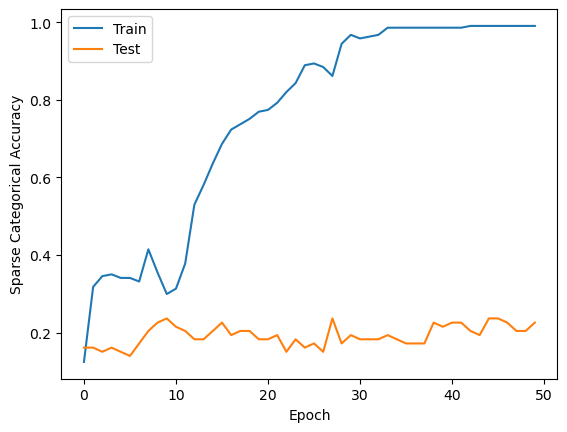

In [73]:
plt.plot(txt_class.history['sparse_categorical_accuracy'])
plt.plot(txt_class.history['val_sparse_categorical_accuracy'])
plt.ylabel('Sparse Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

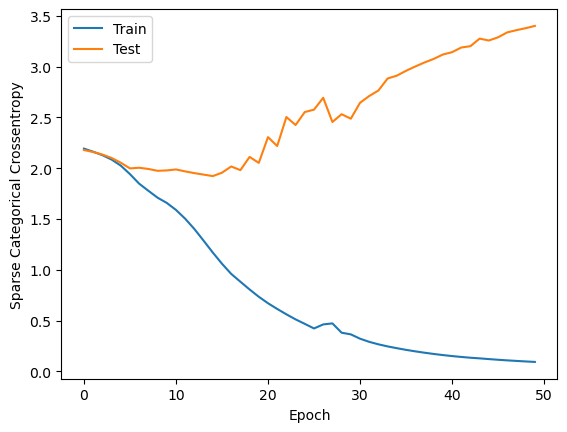

In [74]:
plt.plot(txt_class.history['sparse_categorical_crossentropy'])
plt.plot(txt_class.history['val_sparse_categorical_crossentropy'])
plt.ylabel('Sparse Categorical Crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

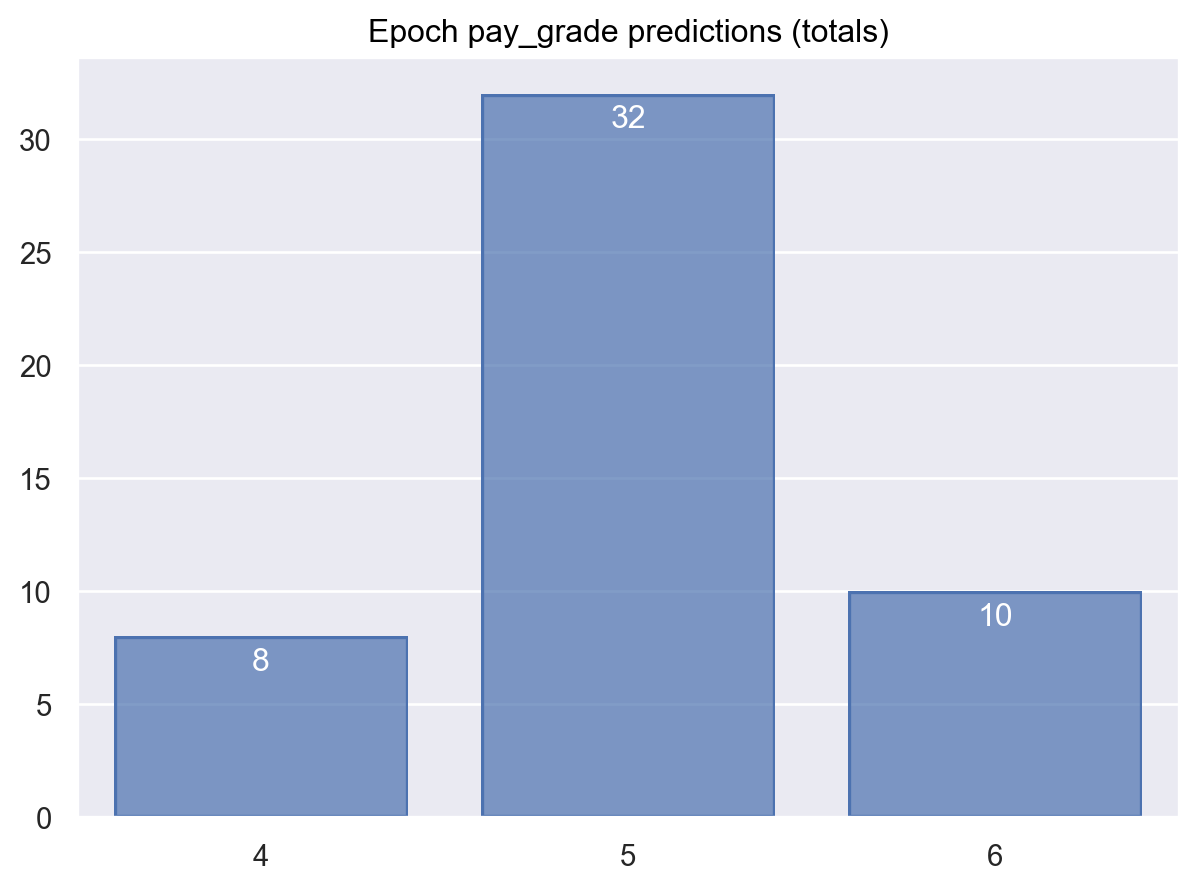

In [75]:
pred = (np.argmax(txt_class.history['f1_score'], axis=-1)+1)
epoch_values, counts = np.unique(pred, return_counts=True)

(so.Plot(x=epoch_values.astype('str'), y=counts, text=counts)
 .add(so.Bar())
 .add(so.Text(color='w', valign='top'))
 ).label(title='Epoch pay_grade predictions (totals)')


## K-neighbors Classifier

##### Create vectorizer for classifier using term frequency inverse document frequency

In [77]:
knn_vectorize = TextVectorization(max_tokens=size, output_mode='tf_idf', pad_to_max_tokens=True)
knn_vectorize.adapt(tensor)

##### Train basic model

In [78]:
knn_train, knn_test = knn_vectorize(tensor_train), knn_vectorize(tensor_test)

knn = KNeighborsClassifier(n_neighbors=5)  # Using 3 nearest neighbors
knn.fit(knn_train, y_train)

# Step 4: Make Predictions on the Test Set
y_pred = knn.predict(knn_test)

# Step 5: Evaluate the Model
print("Classification Report:")
print(classification_report(y_test, y_pred))   

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.04      0.67      0.08         3
           3       0.00      0.00      0.00         9
           4       0.17      0.44      0.25        16
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         1

    accuracy                           0.10        93
   macro avg       0.02      0.12      0.04        93
weighted avg       0.03      0.10      0.04        93



c:\Users\pmaye\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pmaye\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pmaye\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [79]:
# Train a classifier for different values of k
results = []
for k in range(9, 55):
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine').fit(knn_train, y_train)
    y_pred = knn.predict(knn_test)
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_test, y_pred)
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
best_k = results['k'][np.where(results==max(results['accuracy']))[0][0]]
best_acc = max(results['accuracy'])
print(f'The best accuracy, {best_acc*100:.2f}%, was obtained using {best_k} neighbors.')

The best accuracy, 25.81%, was obtained using 39 neighbors.


##### Evaluate

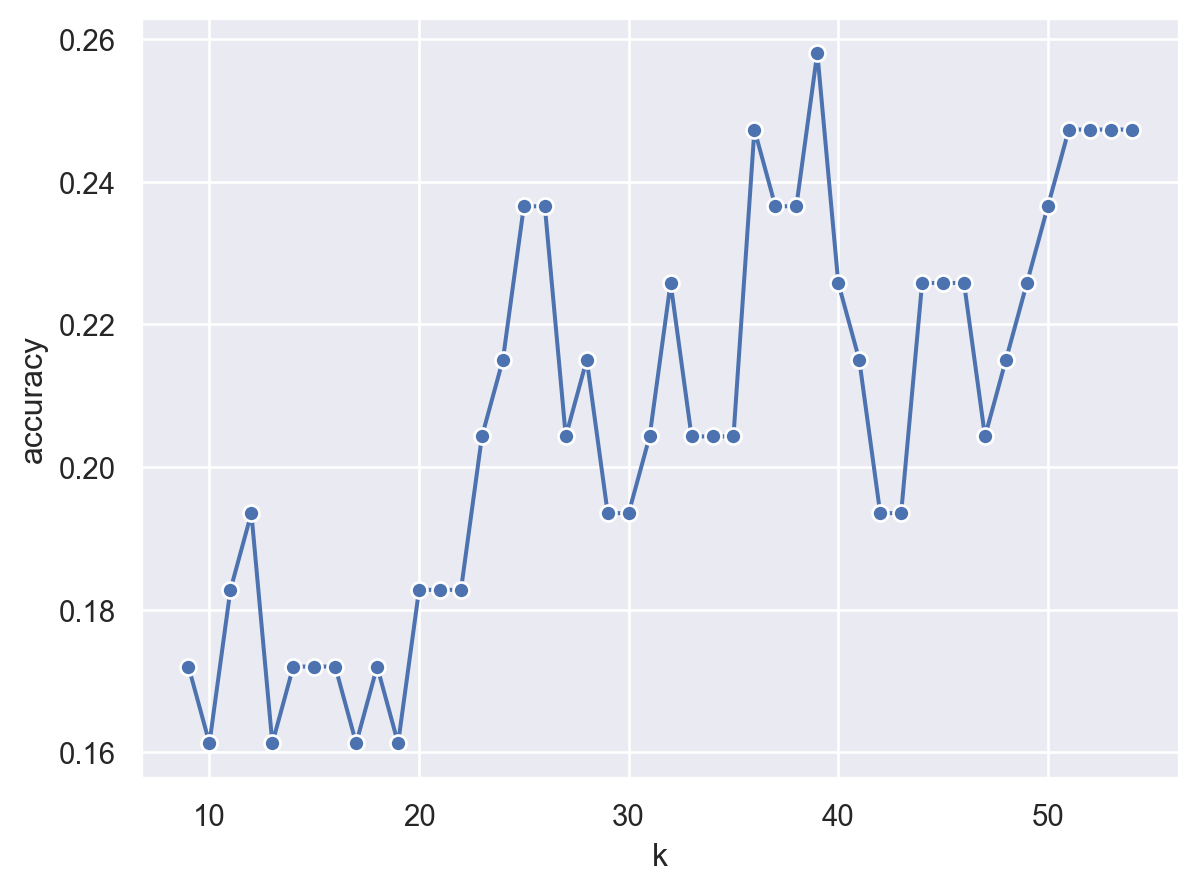

In [69]:
so.Plot(results, 'k', 'accuracy').add(so.Line(marker="o", edgecolor="w"))

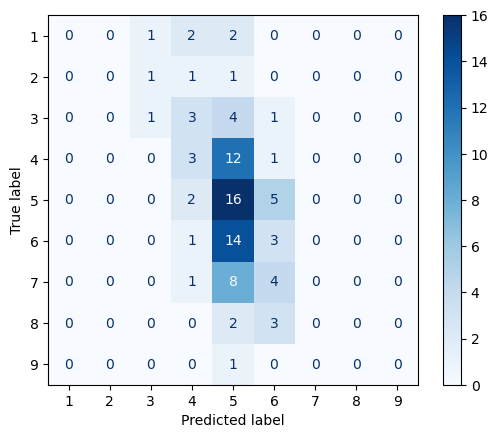

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

plt.show()